# Keras ResNet50 Feature Extraction #

### Importing necessary libraries and modules ###

In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os

### Define the function to extract features ###

In [2]:
def extract_features(model, folder_path):
    """
    Extract features from images using a pre-trained model.

    Args:
    - model (tensorflow.keras.models.Model): Pre-trained model for feature extraction.
    - folder_path (str): Path to the folder containing image files.

    Returns:
    - features (numpy.ndarray): Extracted features from images.
    """
    # Get a list of all image files in the folder
    img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Use list comprehension to process images and extract features
    features = []
    for img_path in img_paths:
        try:
            img = image.load_img(img_path, target_size=model.input_shape[1:3])
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array)
            features.append(feature)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    # Stack the extracted features into a single NumPy array
    features = np.vstack(features)

    return features


### Load the pre-trained ResNet50 model and create a new model with convolutional base only ###

In [3]:
# Load the pre-trained ResNet50 model with top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3)) # Adjust input_shape accordingly

# Create a new model that includes only the convolutional base of ResNet50
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


### Specify folder paths for ASD and non-ASD child face image sets ###

In [6]:
# Specify folder paths for ASD and non-ASD child face image sets
asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD'
non_asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD'

### Extract features for ASD child faces ###

In [7]:
# Extract features for ASD child faces
asd_features = extract_features(model, asd_folder_path)

1/1 [==============================] - 0s 101ms/step


### Extract features for non-ASD child faces ###

In [8]:
# Extract features for non-ASD child faces
non_asd_features = extract_features(model, non_asd_folder_path)

1/1 [==============================] - 0s 72ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/child-1617.png: cannot identify image file <_io.BytesIO object at 0x295629c70>
1/1 [==============================] - 0s 78ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/additional1178.png: cannot identify image file <_io.BytesIO object at 0x13e69d9a0>
1/1 [==============================] - 0s 72ms/step


### Save the extracted features for later use in training ###

In [9]:
# Save the extracted features for later use in training
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/asd_features.npy', asd_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/non_asd_features.npy', non_asd_features)

# Keras ResNet50 Model Training #

### Importing necessary libraries ###

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

### Load the extracted features ###

In [77]:
asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/asd_features.npy')
non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/non_asd_features.npy')

### Create labels for ASD (1) and non-ASD (0) samples ###

In [78]:
asd_labels = np.ones(asd_features.shape[0])
non_asd_labels = np.zeros(non_asd_features.shape[0])

### Concatenate features and labels ###

In [79]:
X = np.concatenate([asd_features, non_asd_features], axis=0)
y = np.concatenate([asd_labels, non_asd_labels])

### Split the data into training and testing sets ###

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build a simple neural network ###

In [81]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### Compile the model ###

In [82]:
model.compile(optimizer=LegacyAdam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Train the model ###

In [84]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9947 - val_loss: 0.2697 - val_accuracy: 0.9569
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0129 - accuracy: 0.9952 - val_loss: 0.3012 - val_accuracy: 0.9559
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0139 - accuracy: 0.9945 - val_loss: 0.2641 - val_accuracy: 0.9559
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0193 - accuracy: 0.9920 - val_loss: 0.2357 - val_accuracy: 0.9539
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0140 - accuracy: 0.9942 - val_loss: 0.2936 - val_accuracy: 0.9589
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0117 - accuracy: 0.9956 - val_loss: 0.2228 - val_accuracy: 0.9594
Epoch 7/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0135 - accuracy: 0.9944 - val_loss: 0.3914 - val_accuracy: 0.9489

### Plot training history ###

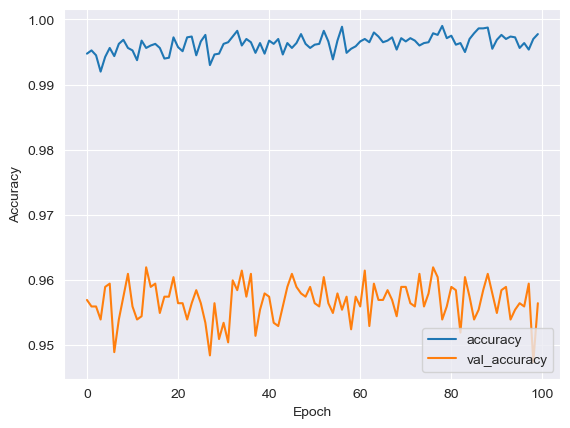

In [85]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Evaluate the model on the test set ###

In [86]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

63/63 [==============================] - 0s 527us/step - loss: 0.3747 - accuracy: 0.9564
Test Loss: 0.3747112452983856
Test Accuracy: 0.9564128518104553


### Predictions ###

In [87]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

63/63 [==============================] - 0s 457us/step


### Classification report ###

In [88]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      1724
         1.0       0.91      0.75      0.82       272

    accuracy                           0.96      1996
   macro avg       0.94      0.87      0.90      1996
weighted avg       0.96      0.96      0.95      1996


### Confusion Matrix ###

In [89]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1705   19]
 [  68  204]]


### Plot Confusion Matrix ###

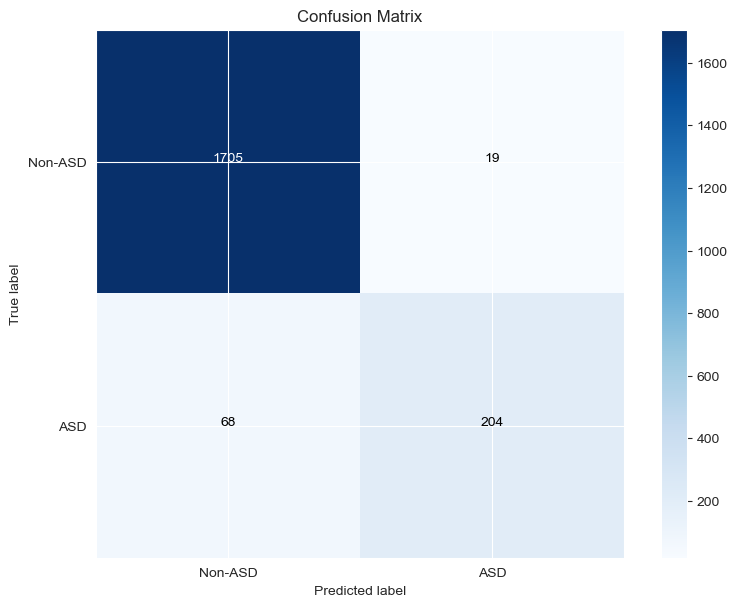

In [90]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-ASD', 'ASD'])
plt.yticks(tick_marks, ['Non-ASD', 'ASD'])

thresh = conf_matrix.max() / 2.
for i, j in ((i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### Save the model for later use ###

In [91]:
model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5')

# Keras ResNet50 Prediction #

### Import necessary libraries ###

In [92]:
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model

### Define paths ###

In [93]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
target_size = (224, 224)

### Load the pre-trained ResNet50 model ###

In [94]:
base_model = ResNet50(weights='imagenet', include_top=True)

### Create a new model that takes the input of ResNet50 and outputs the desired layer ###

In [95]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

### Process the input image ###

In [96]:
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

### Extract features using the full ResNet50 model ###

In [97]:
features = model.predict(img)  # Use the new model

1/1 [==============================] - 0s 414ms/step


### Reshape features to match the expected input shape of trained_model ###

In [98]:
features_reshaped = np.reshape(features, (1, 2048))  # Reshape to (1, 7, 7, 512)

### Load the trained model ###

In [99]:
trained_model = load_model(model_path)

### Predict ASD probability using the trained model and extracted features ###

In [100]:
prediction = trained_model.predict(features_reshaped)[0][0]  # Access the first element for ASD probability

1/1 [==============================] - 0s 33ms/step


### Print prediction ###

In [101]:
print("Prediction:", prediction)

Prediction: 0.99999917


### Format prediction to display only 5 decimal places ###

In [102]:
formatted_prediction = "{:.5f}".format(prediction)
print("Formatted Prediction:", formatted_prediction)

Formatted Prediction: 1.00000


### Round prediction to 2 decimal places ###

In [103]:
rounded_prediction = round(prediction, 2)
print("Rounded Prediction:", rounded_prediction)

Rounded Prediction: 1.0


### Determine and print the predicted class based on the threshold ###

In [104]:
if rounded_prediction > 0.5:
    print("Predicted ASD with probability:", rounded_prediction)
else:
    print("Predicted non-ASD with probability:", 1 - rounded_prediction)

Predicted ASD with probability: 1.0


# XAI LIME #

### Import necessary libraries ###

In [11]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from lime.lime_image import LimeImageExplainer
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

### Provide the path to the image file ###

In [12]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg' 

### Provide the model path ###

In [13]:
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
target_size = (224, 224)

### Load the pre-trained ResNet50 model with top layers included ###

In [14]:
base_model = ResNet50(weights='imagenet', include_top=True)

### Take the output of the base model up to the last convolutional layer ###

In [15]:
x = base_model.get_layer('avg_pool').output

### Add a new dense layer for output ###

In [16]:
x = Dense(2048, activation='relu')(x)
x = Reshape((1, 1, 2048))(x) 
x = GlobalAveragePooling2D()(x)
prediction = Dense(1, activation='sigmoid')(x)

### Create a new model that takes the input of ResNet50 and outputs the desired layer ###

In [17]:
model = Model(inputs=base_model.input, outputs=prediction)

### Process the input image ###

In [18]:
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

### Preprocess the image for the explainer by dividing pixel values by 255 ###

In [19]:
img_scaled = img / 255.0

### Predict ASD probability using the trained model and extracted features ###

1/1 [==============================] - 1s 587ms/step
prediction: 0.61564
Predicted probability: 0.62
Predicted ASD with probability: 0.62


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 388ms/step


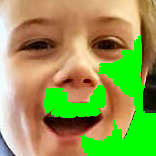

In [20]:
prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
print("prediction: {:.5f}".format(prediction))

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    explainer = LimeImageExplainer()

    # Generate an explanation for the prediction using the explainer object
    explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)

    # Visualize the explanation using matplotlib
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Resize the explanation mask to match the original image dimensions
    mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

    # Convert the mask to the original image mode
    original_image = Image.open(input_image_path)
    #original_image = original_image.convert("L")  # Convert the original image to grayscale
    original_width, original_height = original_image.size
    original_mode = original_image.mode

    # Overlay the explanation mask on the original image
    mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    original_image = np.array(original_image)
    original_image[mask > 0.5] = (0, 255, 0)



    # Display the original image with the explanation mask
    display(Image.fromarray(original_image))

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

# XAI Grad Cam #

### Import necessary libraries ###

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model

### Define Grad-CAM function ###

In [20]:
def generate_grad_cam(model, img_array, layer_name):
    # Create a model that maps the input image to the desired layer's output
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Compute the gradient of the predicted class with respect to the output feature map of the given layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one

    grads = tape.gradient(predicted_class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

### Define paths ###

In [21]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0649.jpg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
target_size = (224, 224)

### Load the pre-trained ResNet50 model ###

In [22]:
base_model = ResNet50(weights='imagenet', include_top=True)

### Create a new model that takes the input of ResNet50 and outputs the desired layer ###

In [23]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

### Process the input image ###

In [24]:
img_original = cv2.imread(input_image_path)
img_original = cv2.resize(img_original, target_size)
img_for_model = preprocess_input(np.expand_dims(img_original, axis=0))

### Extract features using the full ResNet50 model ###

In [25]:
features = model.predict(img_for_model) # Use the new model

1/1 [==============================] - 1s 1s/step


### Reshape features to match the expected input shape of trained_model ###

In [26]:
features_reshaped = np.reshape(features, (1, 2048 )) # Reshape to (1, 7, 7, 512)

### Load the trained model ###

In [27]:
trained_model = load_model(model_path)

### Predict ASD probability using the trained model and extracted features ###

1/1 [==============================] - 0s 36ms/step
prediction:  1.0
prediction: 1.00000
Predicted probability: 1.00
Predicted ASD with probability: 1.00


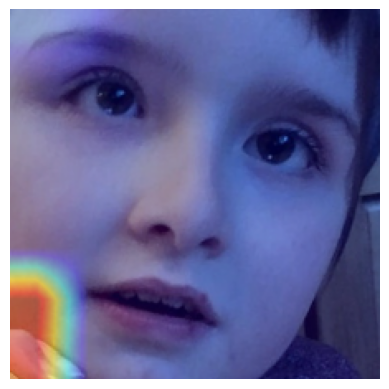

In [28]:
prediction = trained_model.predict(features_reshaped)[0][0] # Access the first element for ASD probability
print("prediction: ", prediction)
print("prediction: {:.5f}".format(prediction))

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    # Visualize the Grad-CAM heatmap
    heatmap = generate_grad_cam(model, img_for_model, 'conv5_block3_out')

    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

    # Apply colormap for better visualization
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)

    # Display the superimposed image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


In [ ]:
# import cv2
# import numpy as np
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.models import Model, load_model
# from lime.lime_image import LimeImageExplainer
# from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense
# import matplotlib.pyplot as plt
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt
# from skimage.segmentation import mark_boundaries
# 
# # Define paths
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
# target_size = (224, 224)
# 
# # Load the pre-trained ResNet50 model
# base_model = ResNet50(weights='imagenet', include_top=True)
# 
# x = base_model.get_layer('avg_pool').output
# x = Dense(2048, activation='relu')(x)
# x = Reshape((1, 1, 2048))(x) # Add this line to reshape the output of GlobalAveragePooling2D
# x = GlobalAveragePooling2D()(x)
# prediction = Dense(1, activation='sigmoid')(x)
# 
# # Create a new model that takes the input of ResNet50 and outputs the desired layer
# model = Model(inputs=base_model.input, outputs=prediction)
# 
# # Process the input image
# img = cv2.imread(input_image_path)
# img = cv2.resize(img, target_size)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)
# 
# img_scaled = img / 255.0
# 
# # Predict ASD probability using the trained model and extracted features
# prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
# print("prediction: {:.5f}".format(prediction))
# 
# rounded_prediction = round(prediction, 2)
# print(f"Predicted probability: {rounded_prediction:.2f}")
# 
# if rounded_prediction > 0.5:
#     print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#     # Explain the prediction using LIME
#     explainer = LimeImageExplainer()
# 
#     # Generate an explanation for the prediction using the explainer object
#     explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0,
#                                              num_samples=10000, random_seed=42)
# 
#     # Visualize the explanation using matplotlib
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5,
#                                                 hide_rest=False)
#     plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#     plt.show()
# 
# else:
#     print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

1/1 [==============================] - 1s 610ms/step
prediction: 0.71437
Predicted probability: 0.71
Predicted ASD with probability: 0.71


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 830ms/step


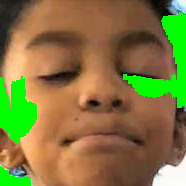

In [34]:
# import cv2
# import numpy as np
# from PIL import Image
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.models import Model, load_model
# from lime.lime_image import LimeImageExplainer
# from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense
# import matplotlib.pyplot as plt
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt
# from skimage.segmentation import mark_boundaries
# 
# # Define paths
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
# target_size = (224, 224)
# 
# # Load the pre-trained ResNet50 model
# base_model = ResNet50(weights='imagenet', include_top=True)
# 
# x = base_model.get_layer('avg_pool').output
# x = Dense(2048, activation='relu')(x)
# x = Reshape((1, 1, 2048))(x) # Add this line to reshape the output of GlobalAveragePooling2D
# x = GlobalAveragePooling2D()(x)
# prediction = Dense(1, activation='sigmoid')(x)
# 
# # Create a new model that takes the input of ResNet50 and outputs the desired layer
# model = Model(inputs=base_model.input, outputs=prediction)
# 
# # Process the input image
# img = cv2.imread(input_image_path)
# img = cv2.resize(img, target_size)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)
# 
# img_scaled = img / 255.0
# 
# # Predict ASD probability using the trained model and extracted features
# prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
# print("prediction: {:.5f}".format(prediction))
# 
# rounded_prediction = round(prediction, 2)
# print(f"Predicted probability: {rounded_prediction:.2f}")
# 
# if rounded_prediction > 0.5:
#     print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#     explainer = LimeImageExplainer()
# 
#     # Generate an explanation for the prediction using the explainer object
#     explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)
# 
#     # Visualize the explanation using matplotlib
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
# 
#     # Resize the explanation mask to match the original image dimensions
#     mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)
# 
#     # Convert the mask to the original image mode
#     original_image = Image.open(input_image_path)
#     #original_image = original_image.convert("L")  # Convert the original image to grayscale
#     original_width, original_height = original_image.size
#     original_mode = original_image.mode
# 
#     # Overlay the explanation mask on the original image
#     mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
#     original_image = np.array(original_image)
#     original_image[mask > 0.5] = (0, 255, 0)
# 
# 
# 
#     # Display the original image with the explanation mask
#     display(Image.fromarray(original_image))
# 
# else:
#     print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

Epoch 1/100
250/250 [==============================] - 1s 1ms/step - loss: 0.2352 - accuracy: 0.9039 - val_loss: 0.1578 - val_accuracy: 0.9389
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1619 - accuracy: 0.9317 - val_loss: 0.1394 - val_accuracy: 0.9409
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1456 - accuracy: 0.9401 - val_loss: 0.1367 - val_accuracy: 0.9424
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1325 - accuracy: 0.9488 - val_loss: 0.1436 - val_accuracy: 0.9369
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1186 - accuracy: 0.9543 - val_loss: 0.1212 - val_accuracy: 0.9509
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1107 - accuracy: 0.9584 - val_loss: 0.1365 - val_accuracy: 0.9469
Epoch 7/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1001 - accuracy: 0.9617 - val_loss: 0.1124 - val_accuracy: 0.9524

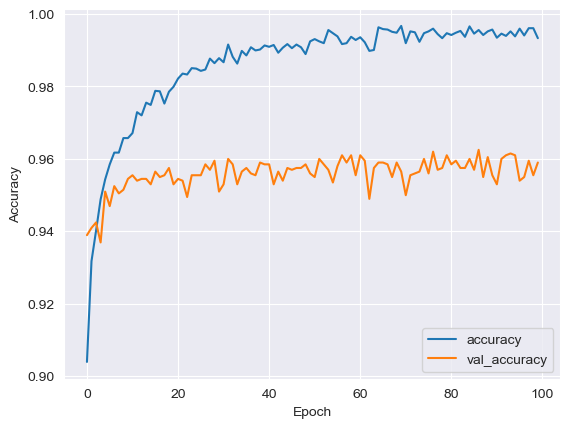

63/63 [==============================] - 0s 1ms/step - loss: 0.2225 - accuracy: 0.9589
Test Loss: 0.2224501222372055
Test Accuracy: 0.9589178562164307
63/63 [==============================] - 0s 943us/step
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1724
         1.0       0.89      0.79      0.84       272

    accuracy                           0.96      1996
   macro avg       0.93      0.89      0.91      1996
weighted avg       0.96      0.96      0.96      1996

Confusion Matrix:
[[1698   26]
 [  56  216]]


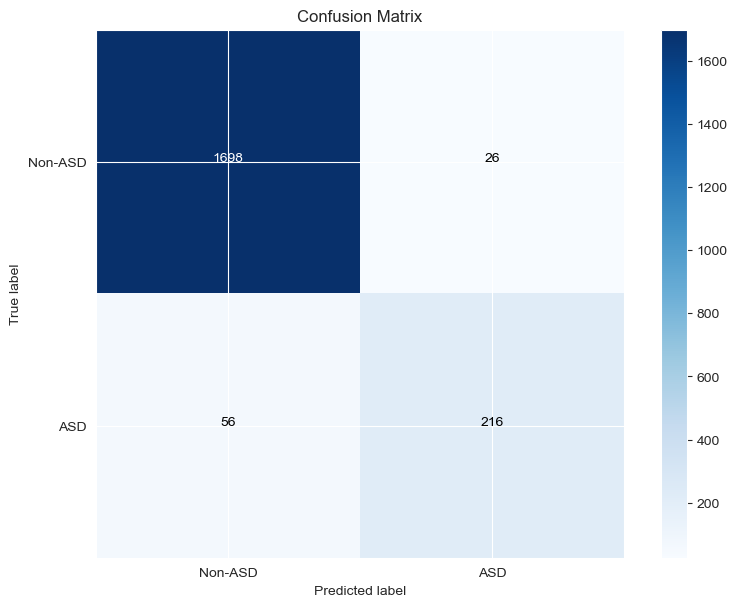

In [75]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix
# 
# # Load the extracted features
# asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/asd_features.npy')
# non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/non_asd_features.npy')
# 
# # Create labels for ASD (1) and non-ASD (0) samples
# asd_labels = np.ones(asd_features.shape[0])
# non_asd_labels = np.zeros(non_asd_features.shape[0])
# 
# # Concatenate features and labels
# X = np.concatenate([asd_features, non_asd_features], axis=0)
# y = np.concatenate([asd_labels, non_asd_labels])
# 
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 
# # Build a simple neural network
# model = Sequential()
# model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# 
# # Compile the model
# model.compile(optimizer=LegacyAdam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# 
# # Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# 
# 
# # Plot training history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.show()
# 
# # Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}')
# print(f'Test Accuracy: {accuracy}')
# 
# # Predictions
# y_pred = model.predict(X_test)
# y_pred_classes = (y_pred > 0.5).astype("int32")
# 
# # Classification report
# print(classification_report(y_test, y_pred_classes))
# 
# # Confusion Matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)
# print("Confusion Matrix:")
# print(conf_matrix)
# 
# # Plot Confusion Matrix
# plt.figure(figsize=(8, 6))
# plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(2)
# plt.xticks(tick_marks, ['Non-ASD', 'ASD'])
# plt.yticks(tick_marks, ['Non-ASD', 'ASD'])
# 
# thresh = conf_matrix.max() / 2.
# for i, j in ((i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])):
#     plt.text(j, i, conf_matrix[i, j],
#              horizontalalignment="center",
#              color="white" if conf_matrix[i, j] > thresh else "black")
# 
# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()
# 
# # Save the model for later use
# model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5')

1/1 [==============================] - 0s 16ms/step
prediction:  1.0
prediction: 1.00000
Predicted probability: 1.00
Predicted ASD with probability: 1.00


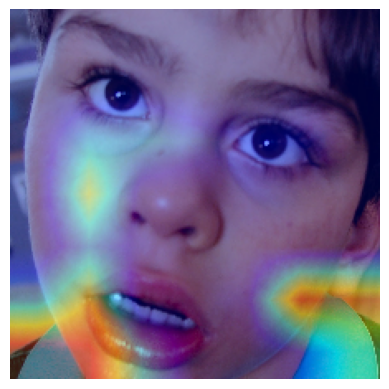

In [9]:
# import cv2
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.models import Model, load_model
# 
# # Define Grad-CAM function
# def generate_grad_cam(model, img_array, layer_name):
#     # Create a model that maps the input image to the desired layer's output
#     grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))
# 
#     # Compute the gradient of the predicted class with respect to the output feature map of the given layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one
# 
#     grads = tape.gradient(predicted_class_output, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
# 
#     # Compute the heatmap
#     heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
#     heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
#     heatmap /= np.max(heatmap)  # Normalize
# 
#     return heatmap
# 
# # Define paths
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0486.jpg' # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
# target_size = (224, 224)
# 
# # Load the pre-trained ResNet50 model
# base_model = ResNet50(weights='imagenet', include_top=True)
# 
# # Create a new model that takes the input of ResNet50 and outputs the desired layer
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
# 
# # Process the input image
# img_original = cv2.imread(input_image_path)
# img_original = cv2.resize(img_original, target_size)
# img_for_model = preprocess_input(np.expand_dims(img_original, axis=0))
# 
# # Extract features using the full ResNet50 model
# features = model.predict(img_for_model) # Use the new model
# 
# # Reshape features to match the expected input shape of trained_model
# features_reshaped = np.reshape(features, (1, 2048 )) # Reshape to (1, 7, 7, 512)
# 
# # Load the trained model
# trained_model = load_model(model_path)
# 
# # Predict ASD probability using the trained model and extracted features
# prediction = trained_model.predict(features_reshaped)[0][0] # Access the first element for ASD probability
# print("prediction: ", prediction)
# print("prediction: {:.5f}".format(prediction))
# 
# rounded_prediction = round(prediction, 2)
# print(f"Predicted probability: {rounded_prediction:.2f}")
# 
# if rounded_prediction > 0.5:
#     print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#     # Visualize the Grad-CAM heatmap
#     heatmap = generate_grad_cam(model, img_for_model, 'conv5_block3_out')
# 
#     # Resize heatmap to match the size of the original image
#     heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
# 
#     # Apply colormap for better visualization
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 
#     # Superimpose the heatmap on the original image
#     superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
# 
#     # Display the superimposed image
#     plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()
# else:
#     print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
